In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
#Loading Libraries
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image

class SketchFaceDataset(Dataset):
    def __init__(self,base_dir,phase='train',transform=None):
        self.sketch_dir=os.path.join(base_dir,phase,'sketches')
        self.original_dir=os.path.join(base_dir,phase,'photos')
        self.transform=transform
        #Get list of sketch files and ensure original files match
        self.sketch_files=sorted(os.listdir(self.sketch_dir))
        self.original_files=sorted(os.listdir(self.original_dir))

    def __len__(self):
        return len(self.sketch_files)

    def __getitem__(self,idx):
        sketch_path=os.path.join(self.sketch_dir,self.sketch_files[idx])
        original_path=os.path.join(self.original_dir,self.original_files[idx])
        sketch=Image.open(sketch_path).convert("RGB")
        original=Image.open(original_path).convert("RGB")
        if self.transform:
            sketch=self.transform(sketch)
            original=self.transform(original)
        return sketch,original


transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#Base directory for the dataset
base_dir="/kaggle/input/person-face-sketches"

#Create datasets for train,val,and test phases
train_dataset=SketchFaceDataset(base_dir,phase='train',transform=transform)
val_dataset=SketchFaceDataset(base_dir,phase='val',transform=transform)
test_dataset=SketchFaceDataset(base_dir,phase='test',transform=transform)

#Create dataloaders for each phase
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.Conv2d(64, out_channels, kernel_size=7, stride=1, padding=3),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride=2):
            """Returns layers of each discriminator block"""
            return [
                nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1),
                nn.InstanceNorm2d(out_filters),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, stride=2),
            *discriminator_block(64, 128, stride=2),
            *discriminator_block(128, 256, stride=2),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [11]:
def adversarial_loss(predicted_output, target):
    return nn.MSELoss()(predicted_output, target)

def cycle_consistency_loss(reconstructed_image, real_image):
    return nn.L1Loss()(reconstructed_image, real_image)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
G_FtoS = Generator().to(device) 
G_StoF = Generator().to(device)  
D_F = Discriminator().to(device) 
D_S = Discriminator().to(device) 

lr = 0.0002
G_optimizer = optim.Adam(list(G_FtoS.parameters()) + list(G_StoF.parameters()), lr=lr, betas=(0.5, 0.999))
D_F_optimizer = optim.Adam(D_F.parameters(), lr=lr, betas=(0.5, 0.999))
D_S_optimizer = optim.Adam(D_S.parameters(), lr=lr, betas=(0.5, 0.999))

lambda_lr = lambda epoch: 1 - max(0, epoch - 100) / float(100)
G_scheduler = optim.lr_scheduler.LambdaLR(G_optimizer, lr_lambda=lambda_lr)
D_F_scheduler = optim.lr_scheduler.LambdaLR(D_F_optimizer, lr_lambda=lambda_lr)
D_S_scheduler = optim.lr_scheduler.LambdaLR(D_S_optimizer, lr_lambda=lambda_lr)

criterion_GAN = adversarial_loss
criterion_cycle = cycle_consistency_loss

fake_face_buffer = []
fake_sketch_buffer = []

Epoch [1/200] Loss G: 1.6247587203979492, Loss D_F: 0.25567716360092163, Loss D_S: 0.13843218982219696
Generated images on fixed input after Epoch 1


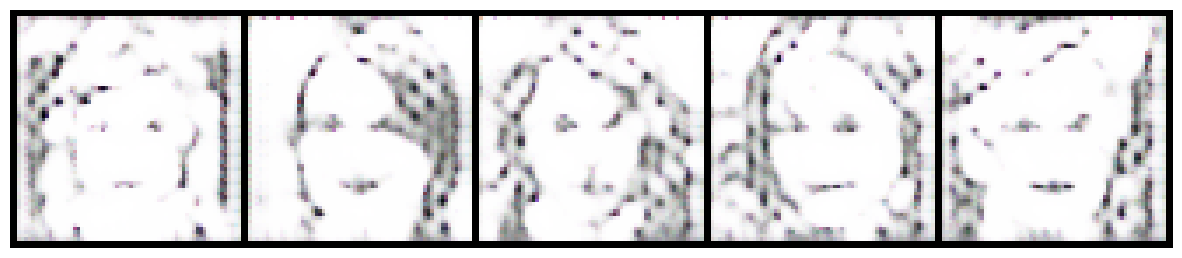

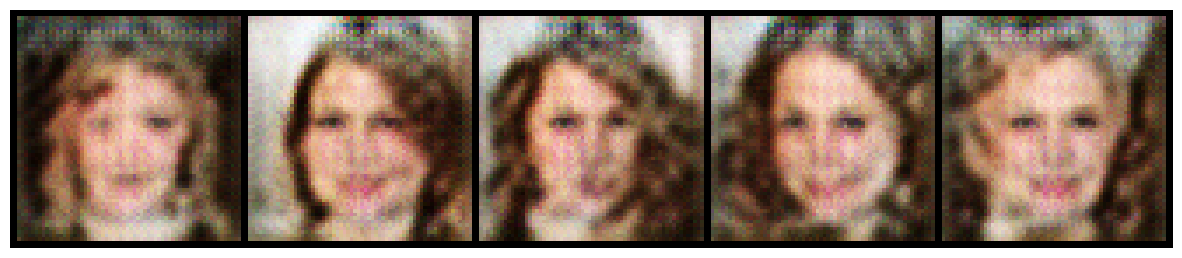

Epoch [2/200] Loss G: 1.7368990182876587, Loss D_F: 0.25184372067451477, Loss D_S: 0.2418535053730011
Generated images on fixed input after Epoch 2


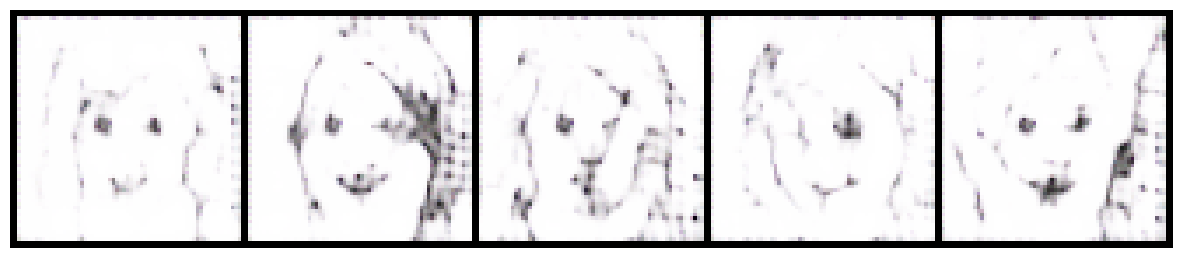

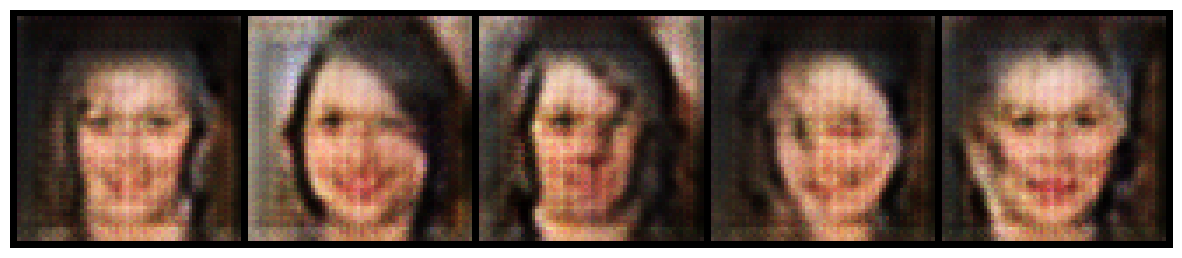

Epoch [3/200] Loss G: 1.1125574111938477, Loss D_F: 0.2610636353492737, Loss D_S: 0.17993582785129547
Generated images on fixed input after Epoch 3


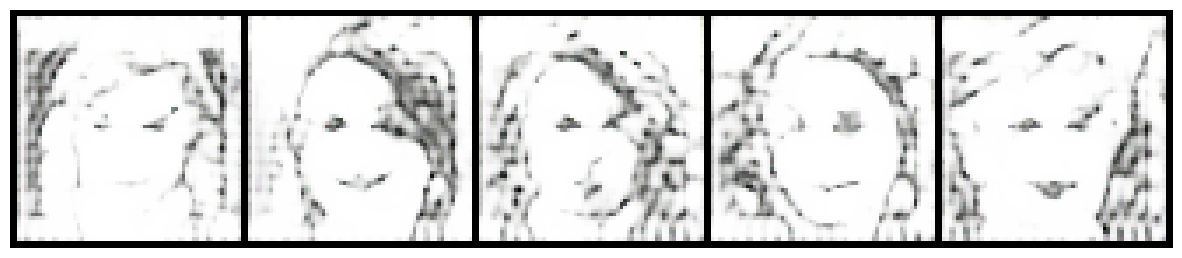

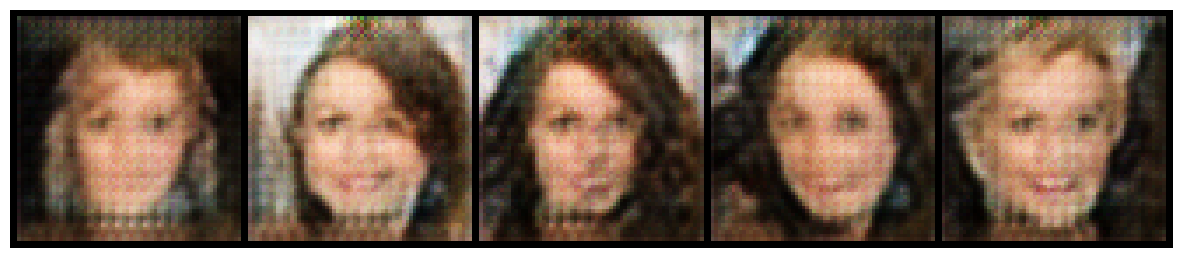

Epoch [4/200] Loss G: 0.9480483531951904, Loss D_F: 0.2458602488040924, Loss D_S: 0.2508419156074524
Generated images on fixed input after Epoch 4


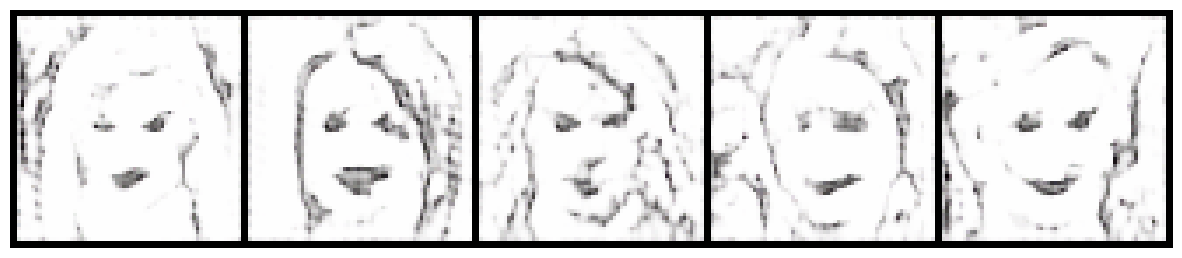

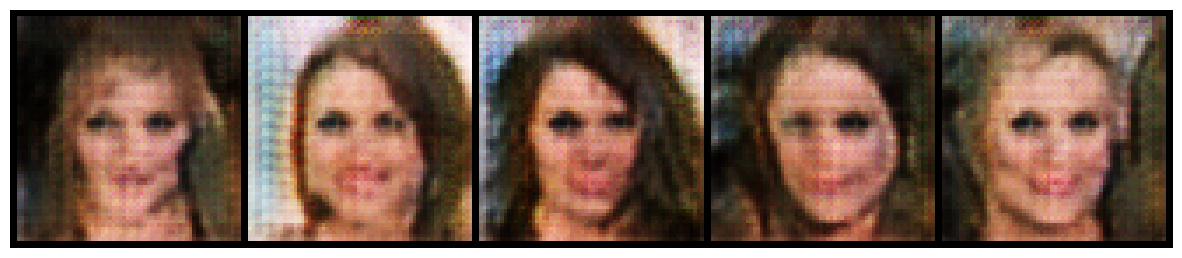

Epoch [5/200] Loss G: 1.630845308303833, Loss D_F: 0.21661928296089172, Loss D_S: 0.10800690948963165
Generated images on fixed input after Epoch 5


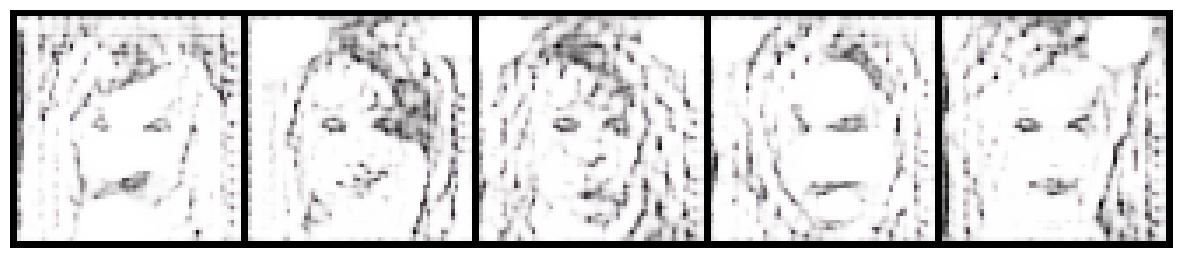

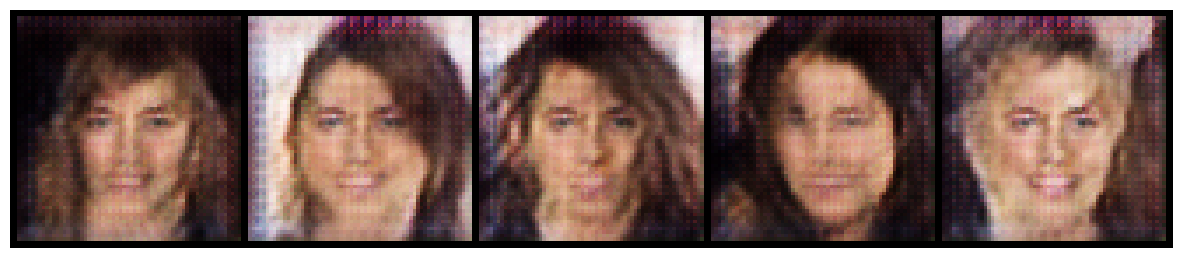

Epoch [6/200] Loss G: 0.9594518542289734, Loss D_F: 0.23233112692832947, Loss D_S: 0.26636961102485657
Generated images on fixed input after Epoch 6


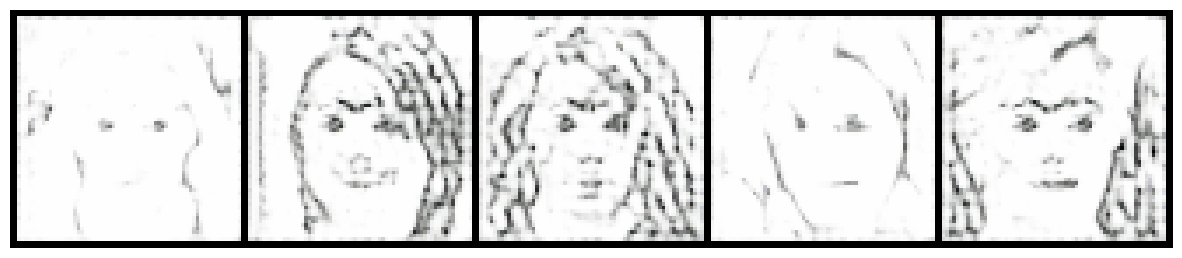

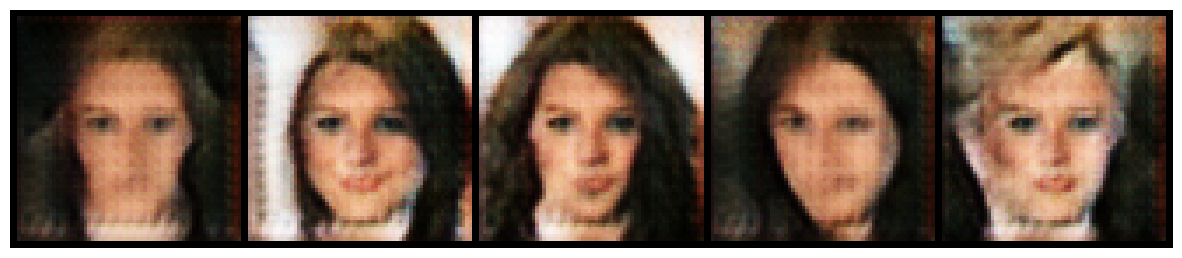

Epoch [7/200] Loss G: 1.8858082294464111, Loss D_F: 0.22313536703586578, Loss D_S: 0.17546170949935913
Generated images on fixed input after Epoch 7


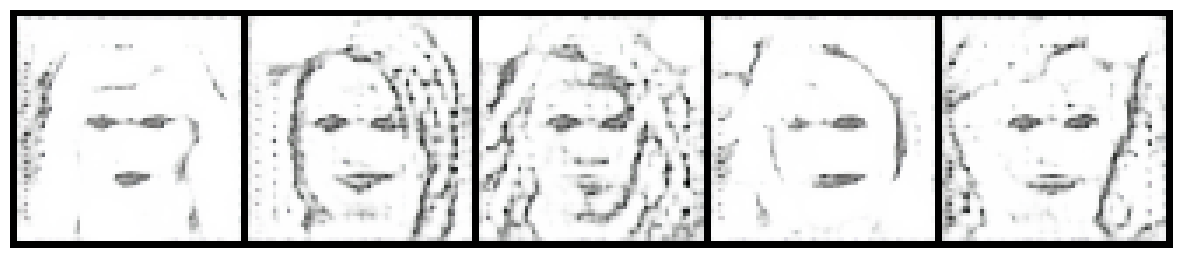

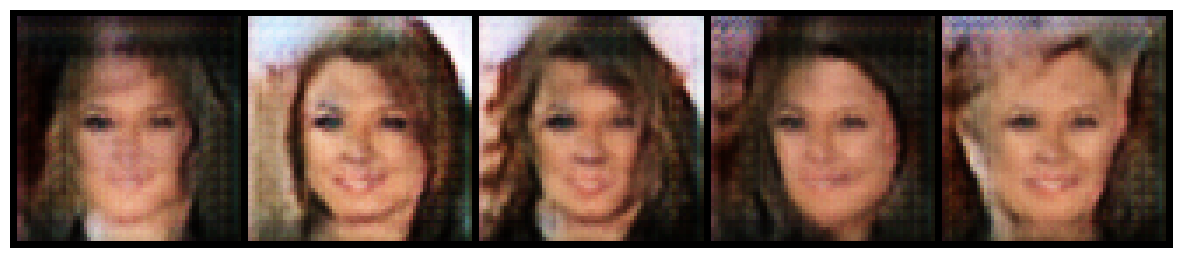

Epoch [8/200] Loss G: 2.031087875366211, Loss D_F: 0.2528004050254822, Loss D_S: 0.019243093207478523
Generated images on fixed input after Epoch 8


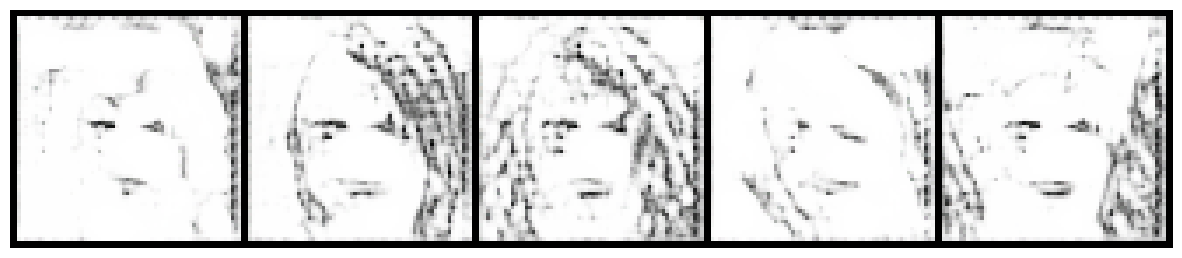

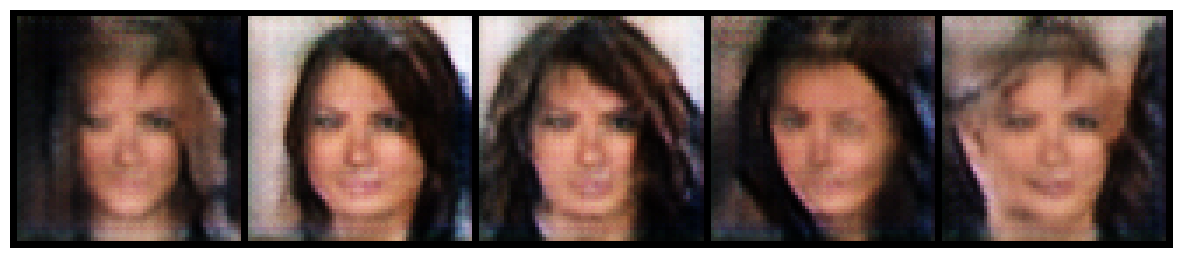

Epoch [9/200] Loss G: 1.1325337886810303, Loss D_F: 0.2454606294631958, Loss D_S: 0.2157856822013855
Generated images on fixed input after Epoch 9


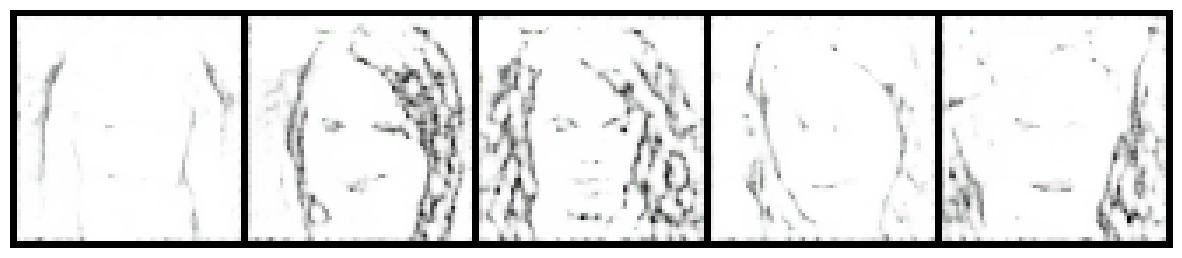

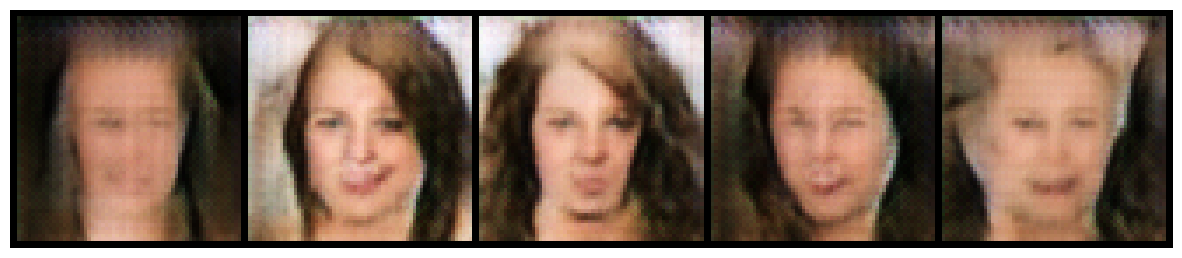

Epoch [10/200] Loss G: 1.2229125499725342, Loss D_F: 0.22652652859687805, Loss D_S: 0.17503339052200317
Generated images on fixed input after Epoch 10


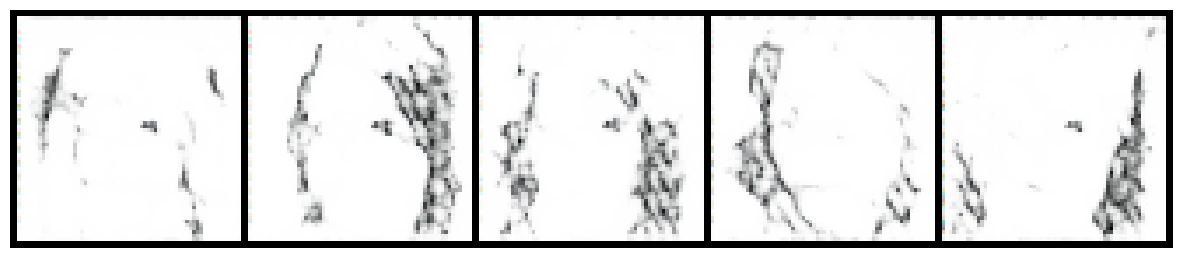

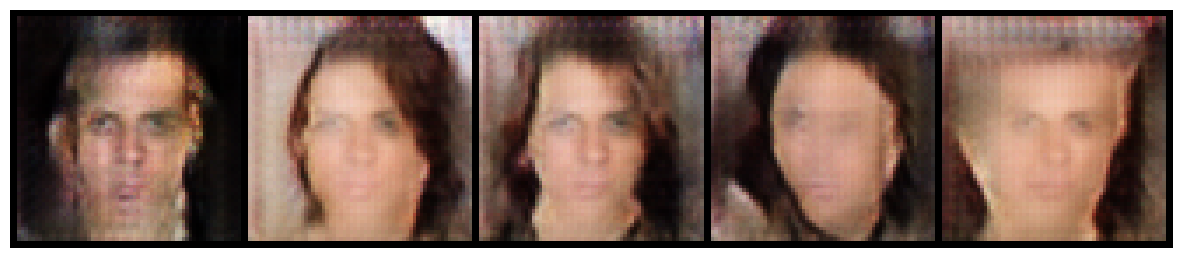

Epoch [11/200] Loss G: 1.247997760772705, Loss D_F: 0.26538026332855225, Loss D_S: 0.13634422421455383
Generated images on fixed input after Epoch 11


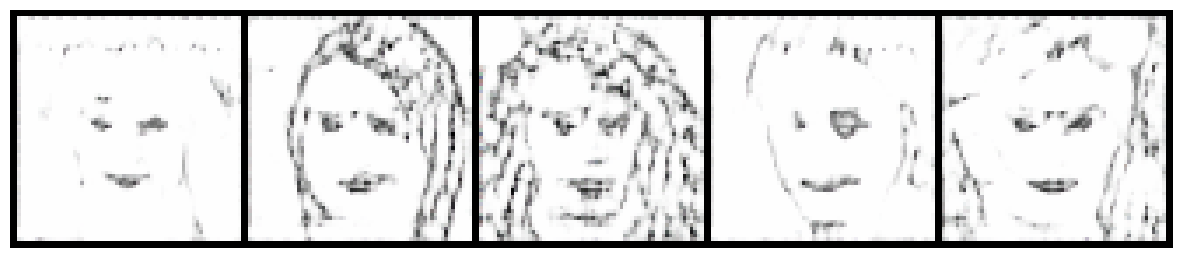

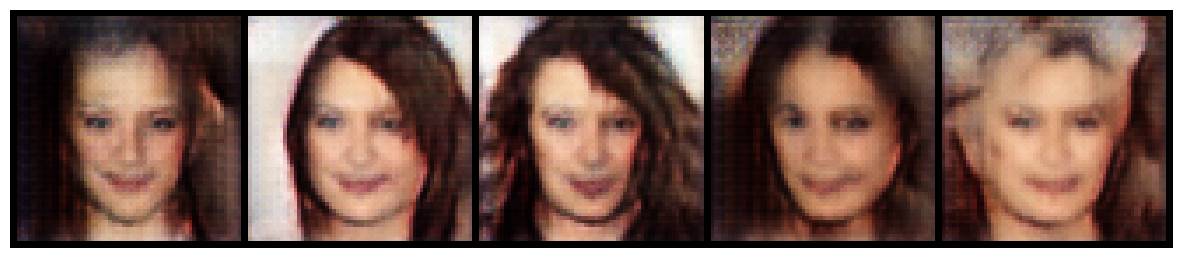

Epoch [12/200] Loss G: 1.744747281074524, Loss D_F: 0.3795605003833771, Loss D_S: 0.18871662020683289
Generated images on fixed input after Epoch 12


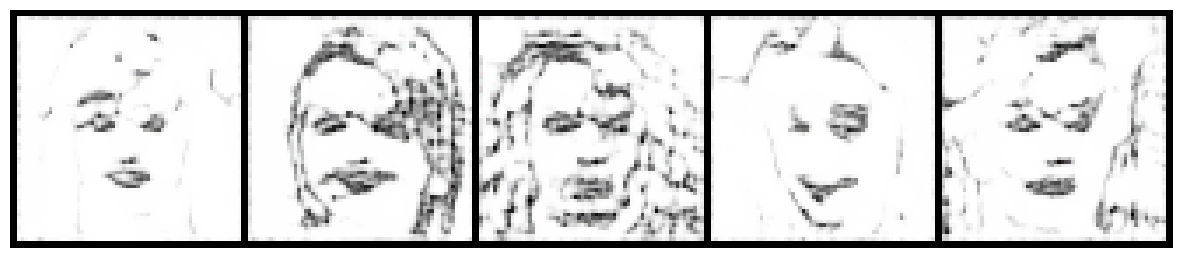

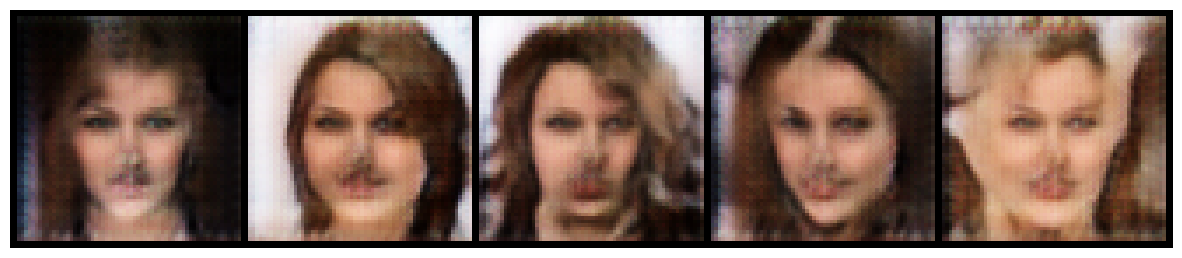

Epoch [13/200] Loss G: 1.1150052547454834, Loss D_F: 0.2420218288898468, Loss D_S: 0.19666074216365814
Generated images on fixed input after Epoch 13


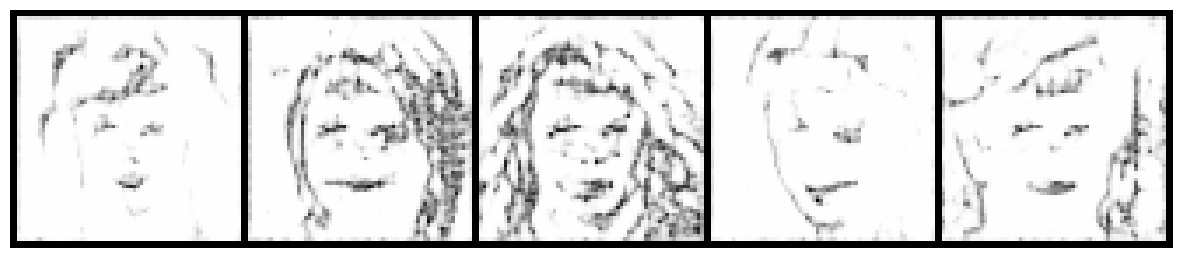

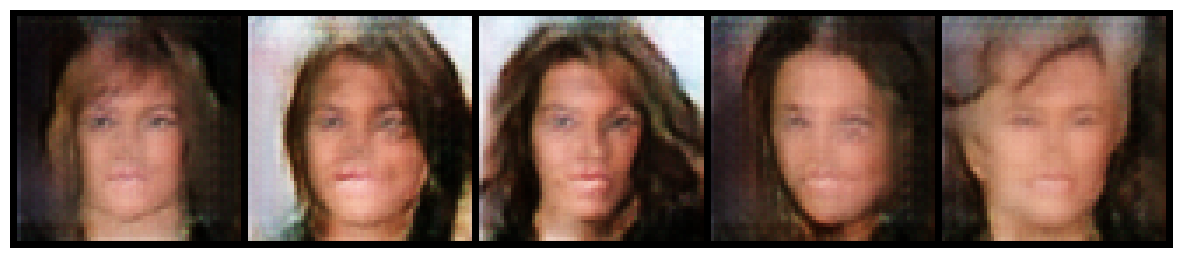

Epoch [15/200] Loss G: 1.126507043838501, Loss D_F: 0.22715085744857788, Loss D_S: 0.19681504368782043
Generated images on fixed input after Epoch 15


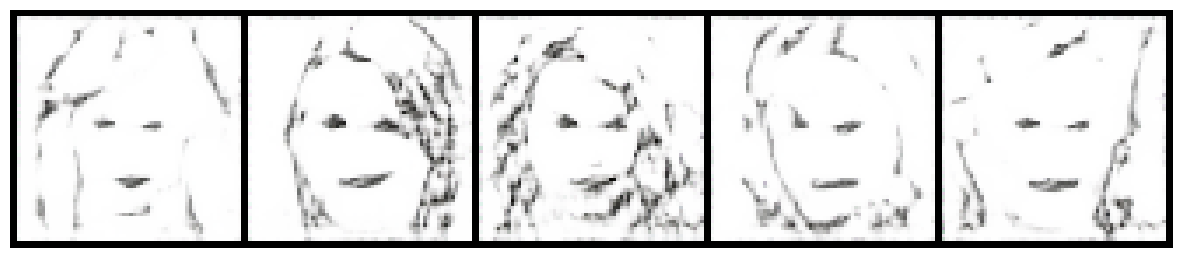

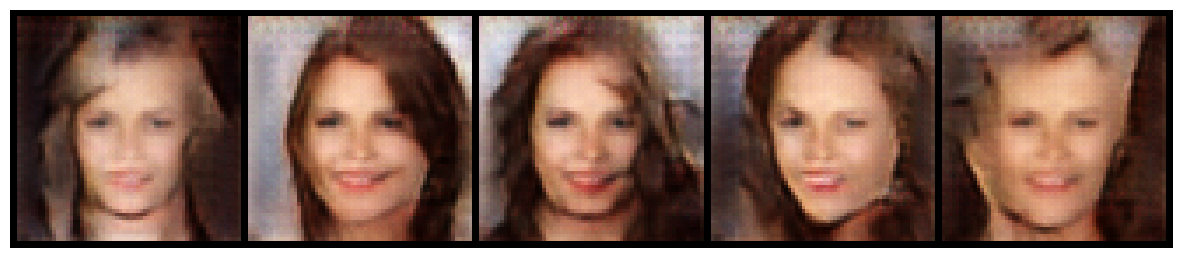

Epoch [16/200] Loss G: 1.031008243560791, Loss D_F: 0.20580485463142395, Loss D_S: 0.18437759578227997
Generated images on fixed input after Epoch 16


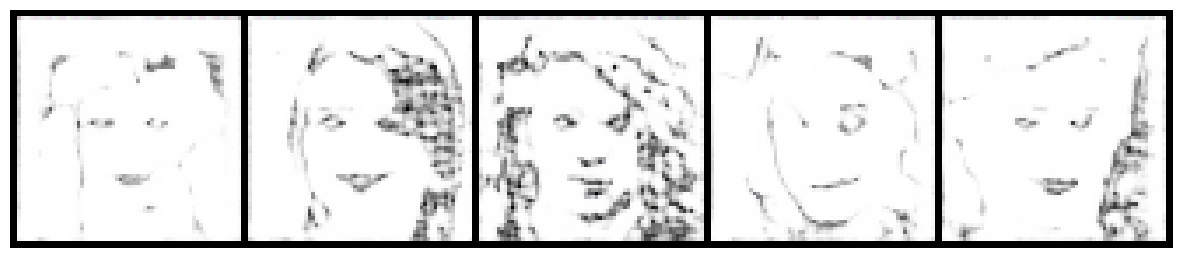

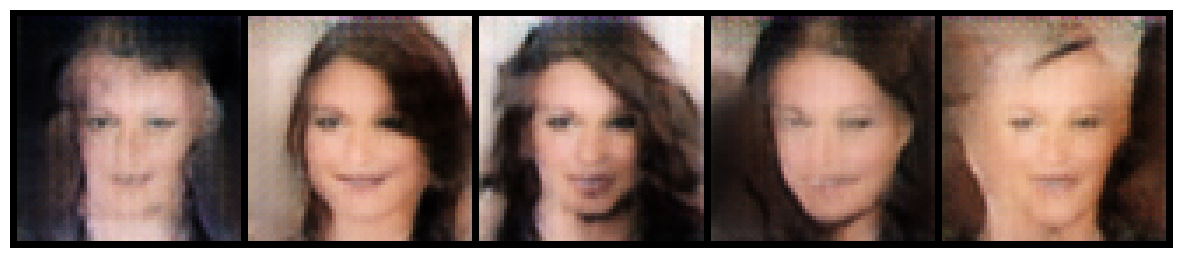

Epoch [17/200] Loss G: 2.390881061553955, Loss D_F: 0.17948134243488312, Loss D_S: 0.06373515725135803
Generated images on fixed input after Epoch 17


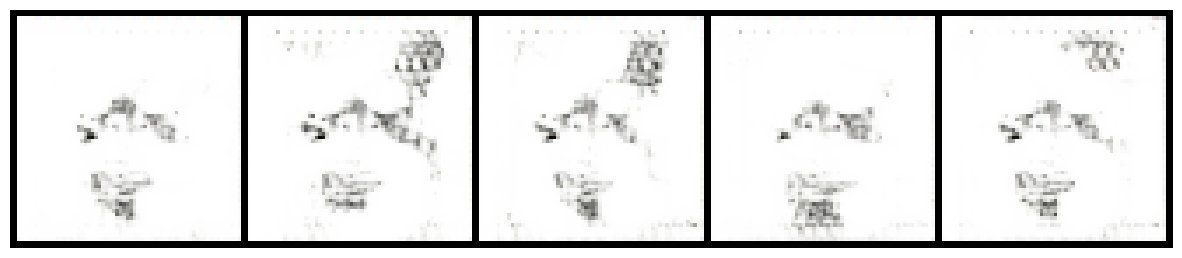

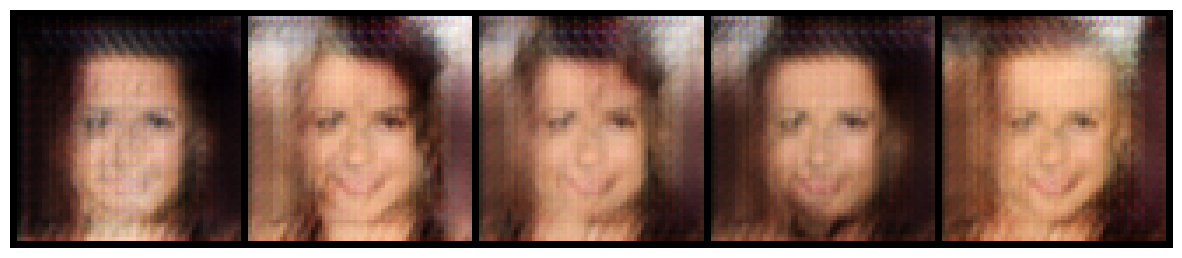

Epoch [18/200] Loss G: 1.2876646518707275, Loss D_F: 0.1987379491329193, Loss D_S: 0.15191411972045898
Generated images on fixed input after Epoch 18


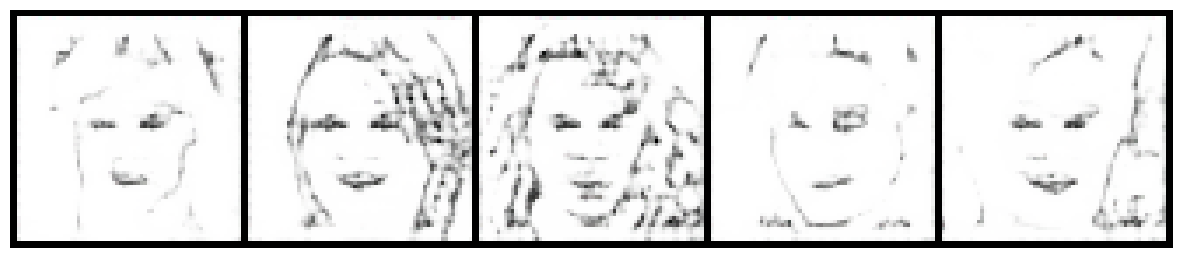

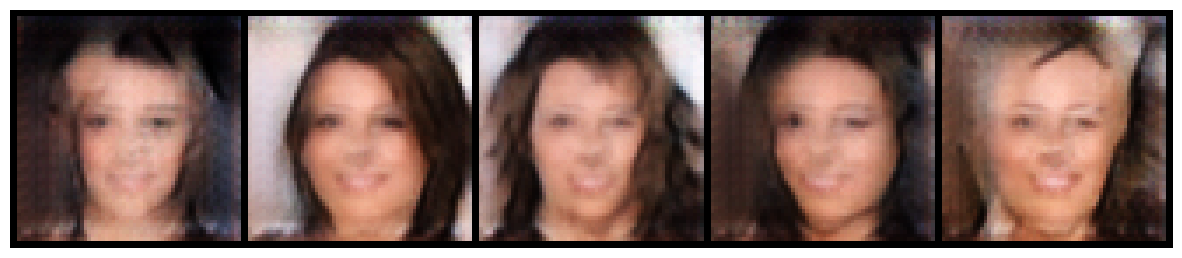

Epoch [19/200] Loss G: 1.5717376470565796, Loss D_F: 0.24011750519275665, Loss D_S: 0.10385186225175858
Generated images on fixed input after Epoch 19


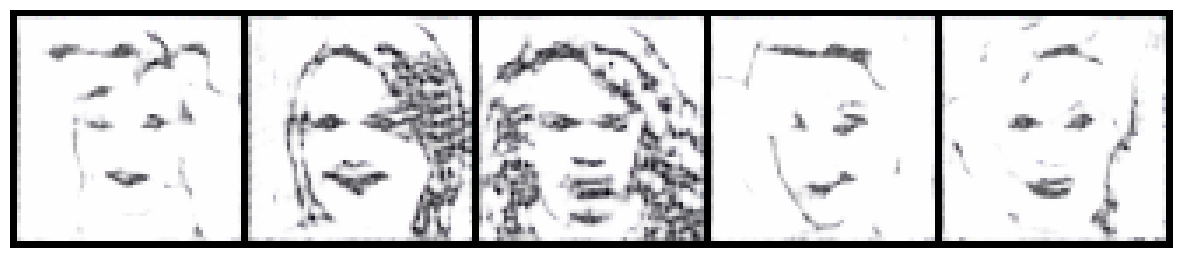

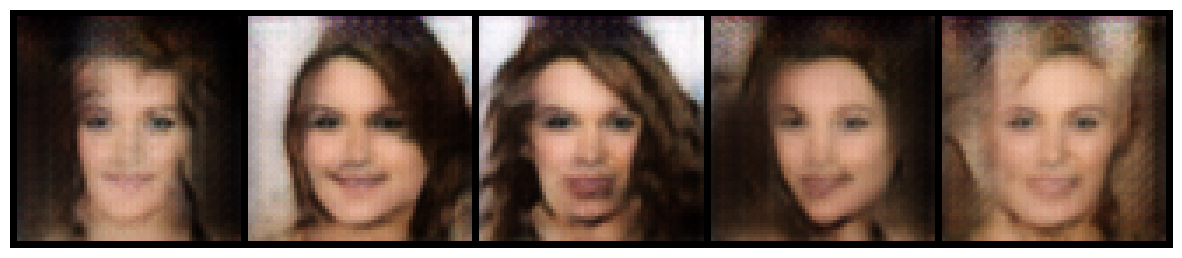

Epoch [20/200] Loss G: 1.2430617809295654, Loss D_F: 0.2221350371837616, Loss D_S: 0.18453653156757355
Generated images on fixed input after Epoch 20


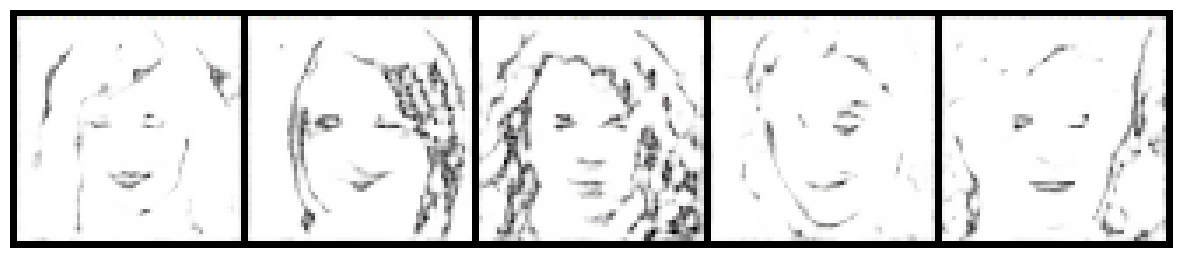

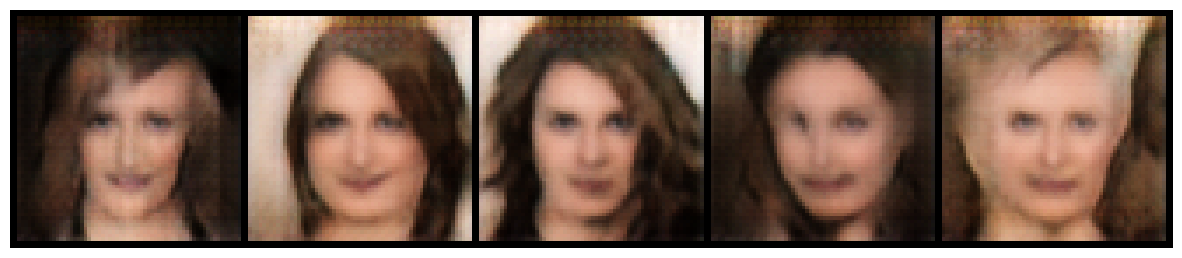

Epoch [21/200] Loss G: 1.164550542831421, Loss D_F: 0.26296818256378174, Loss D_S: 0.08643195033073425
Generated images on fixed input after Epoch 21


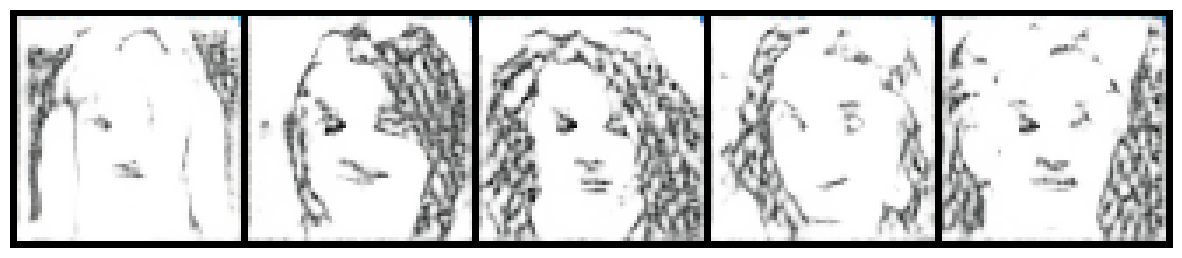

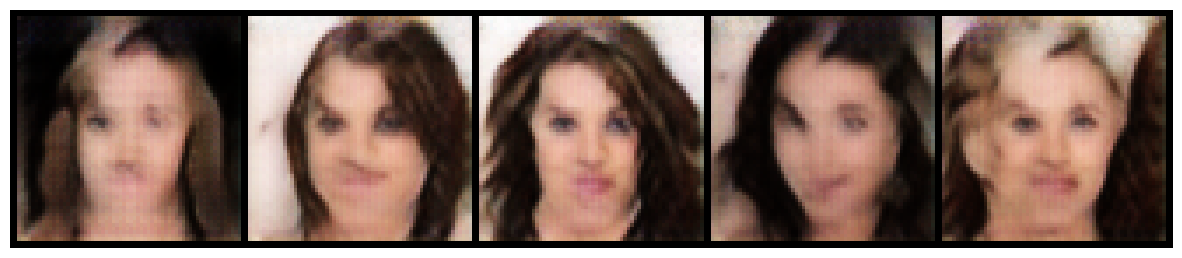

Epoch [22/200] Loss G: 1.6240017414093018, Loss D_F: 0.22058068215847015, Loss D_S: 0.01587061770260334
Generated images on fixed input after Epoch 22


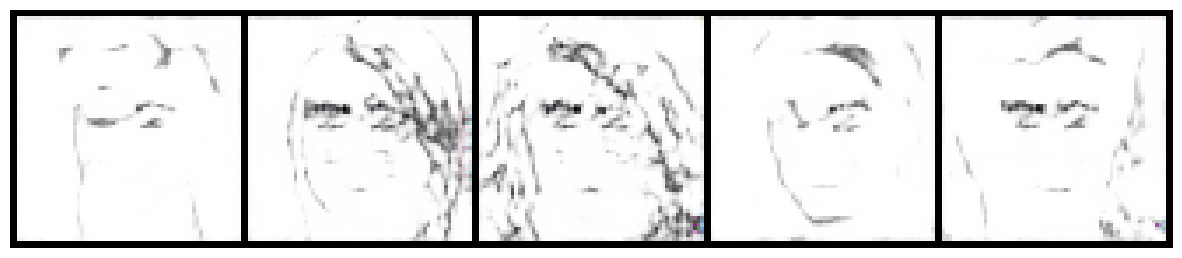

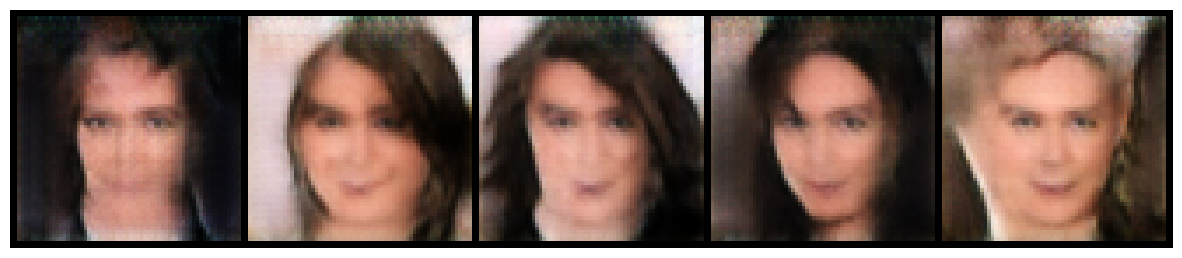

Epoch [23/200] Loss G: 1.574543833732605, Loss D_F: 0.1743977665901184, Loss D_S: 0.031035002321004868
Generated images on fixed input after Epoch 23


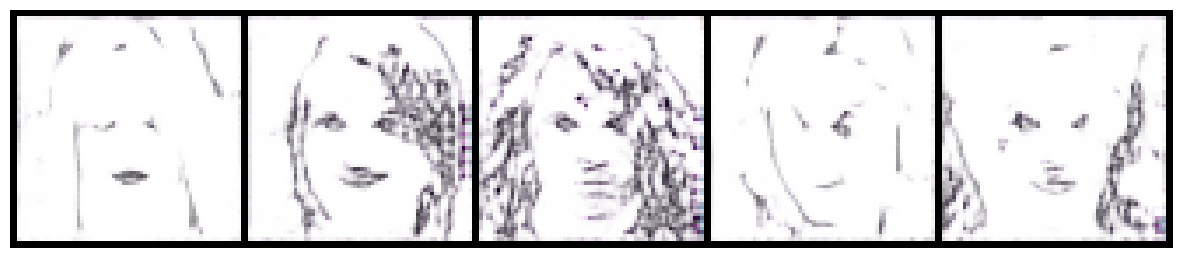

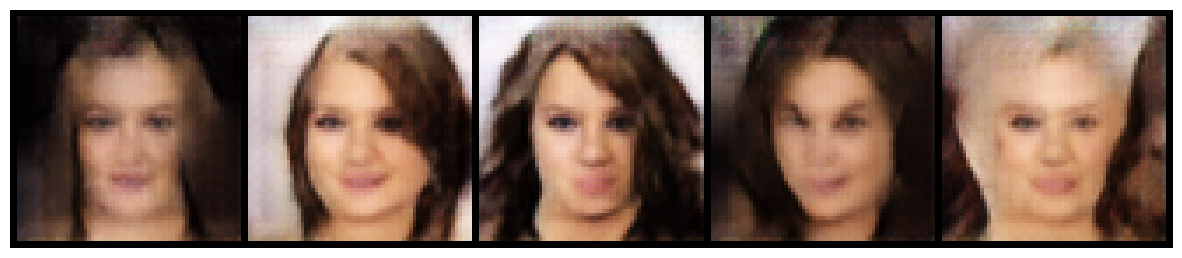

Epoch [24/200] Loss G: 1.7703815698623657, Loss D_F: 0.1998269259929657, Loss D_S: 0.015174923464655876
Generated images on fixed input after Epoch 24


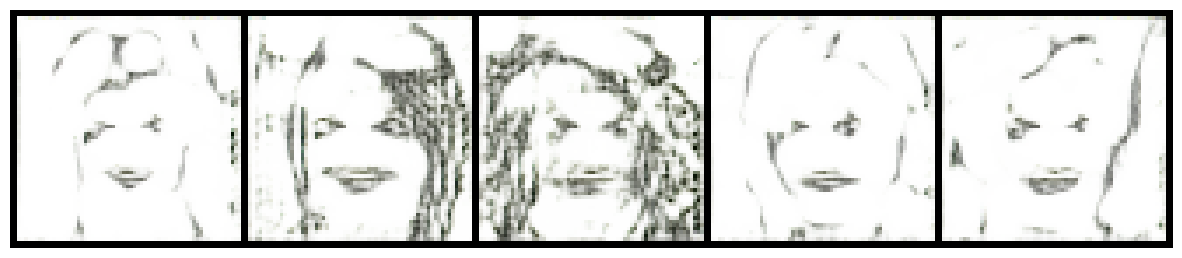

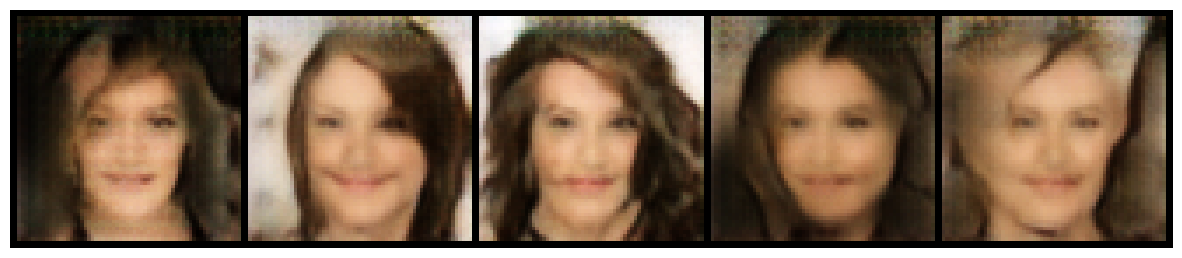

Epoch [25/200] Loss G: 1.2967194318771362, Loss D_F: 0.2495204508304596, Loss D_S: 0.19353258609771729
Generated images on fixed input after Epoch 25


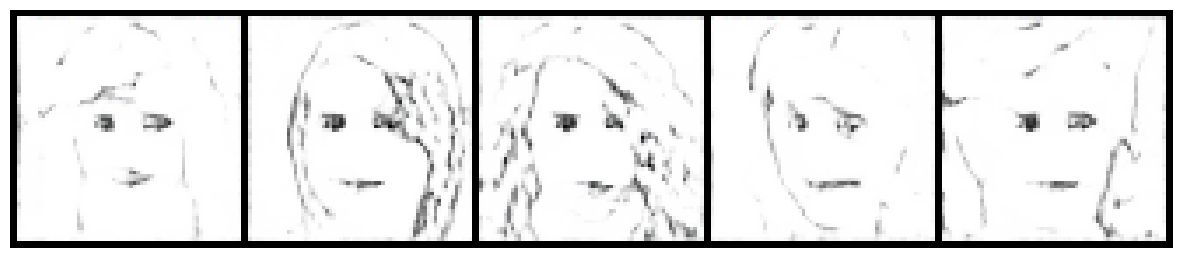

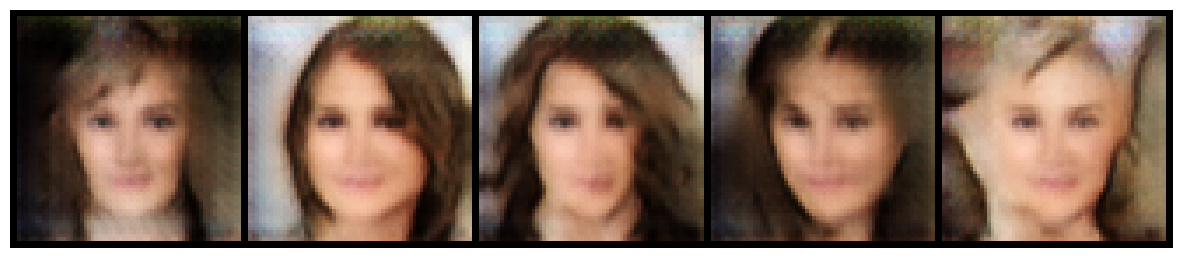

Epoch [26/200] Loss G: 1.194270133972168, Loss D_F: 0.21551619470119476, Loss D_S: 0.19371047616004944
Generated images on fixed input after Epoch 26


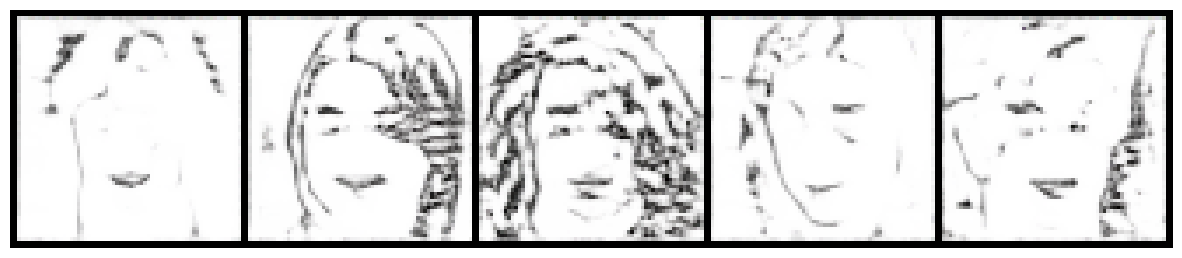

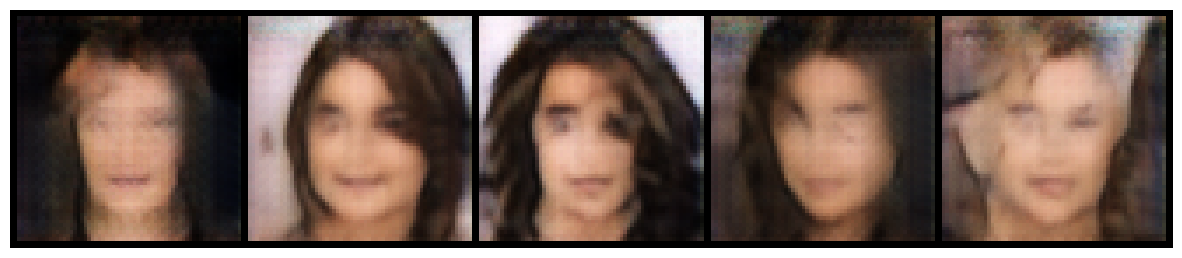

Epoch [27/200] Loss G: 1.2697288990020752, Loss D_F: 0.1886121928691864, Loss D_S: 0.2005336582660675
Generated images on fixed input after Epoch 27


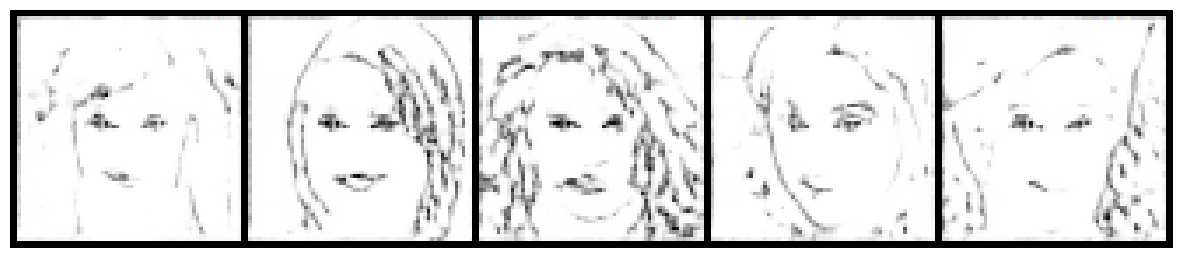

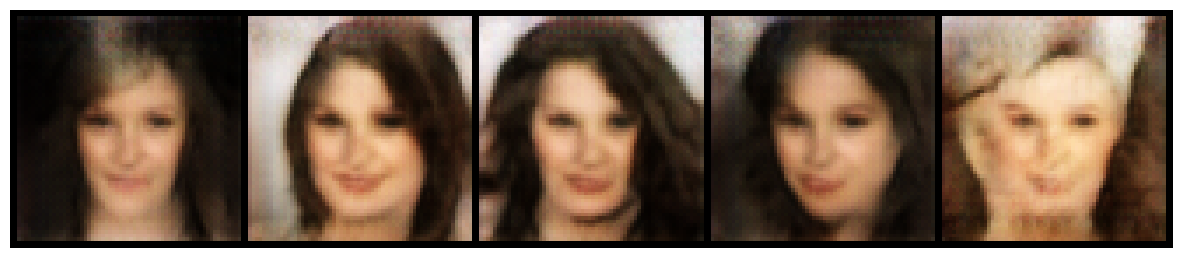

Epoch [28/200] Loss G: 1.6710306406021118, Loss D_F: 0.24045242369174957, Loss D_S: 0.011123469099402428
Generated images on fixed input after Epoch 28


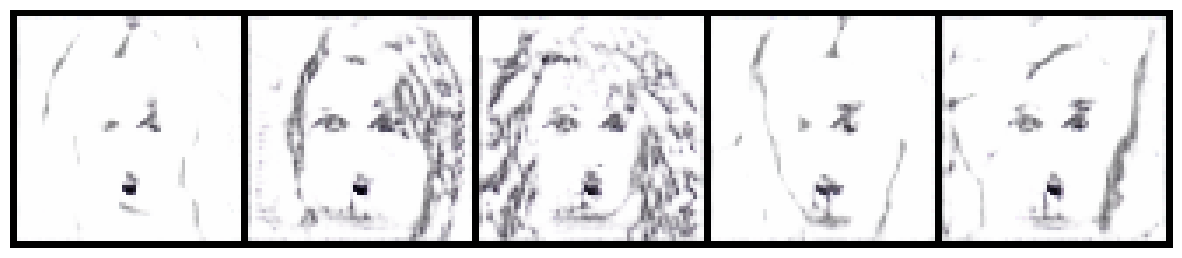

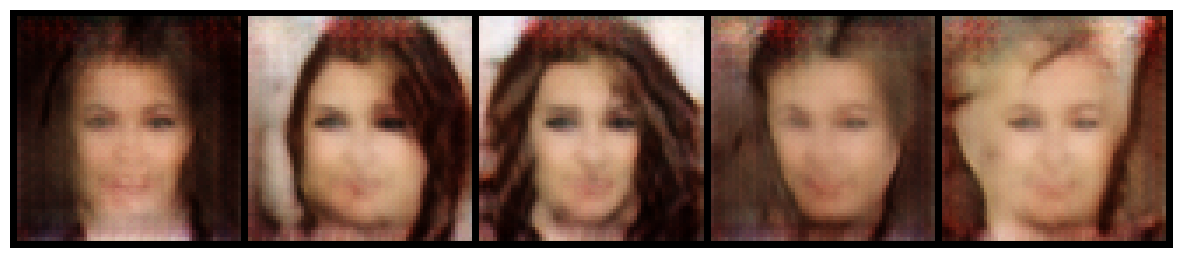

Epoch [29/200] Loss G: 1.32077956199646, Loss D_F: 0.22863131761550903, Loss D_S: 0.1662893295288086
Generated images on fixed input after Epoch 29


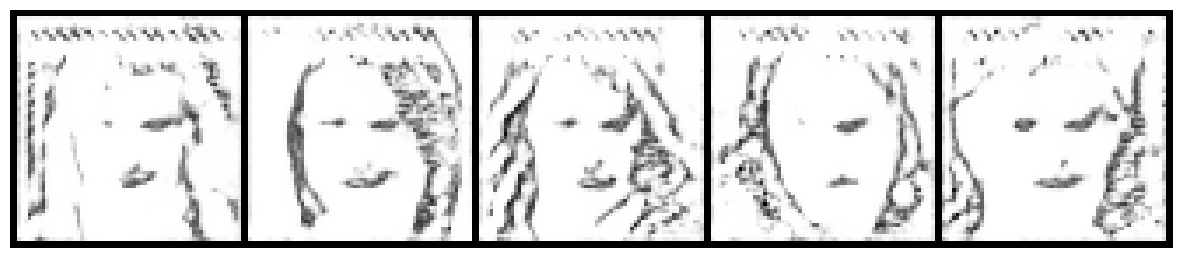

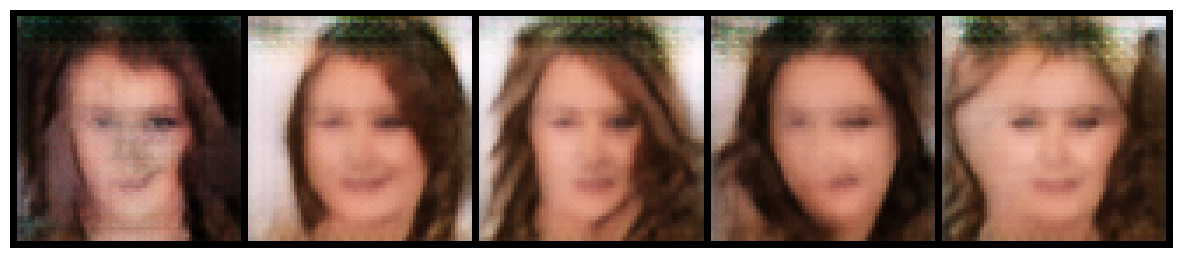

Epoch [30/200] Loss G: 1.2396240234375, Loss D_F: 0.22536665201187134, Loss D_S: 0.18928174674510956
Generated images on fixed input after Epoch 30


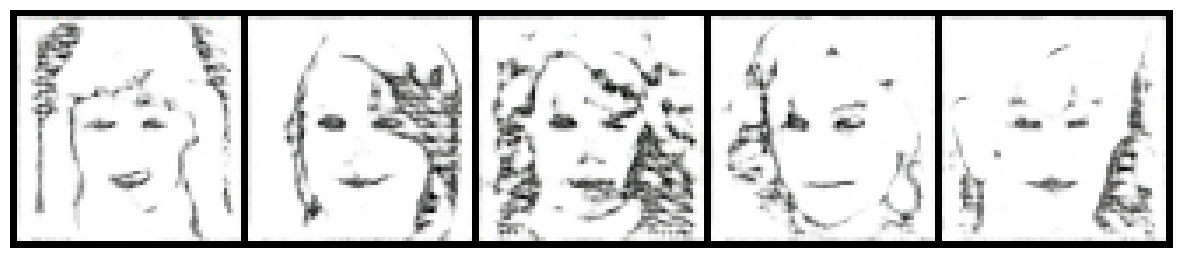

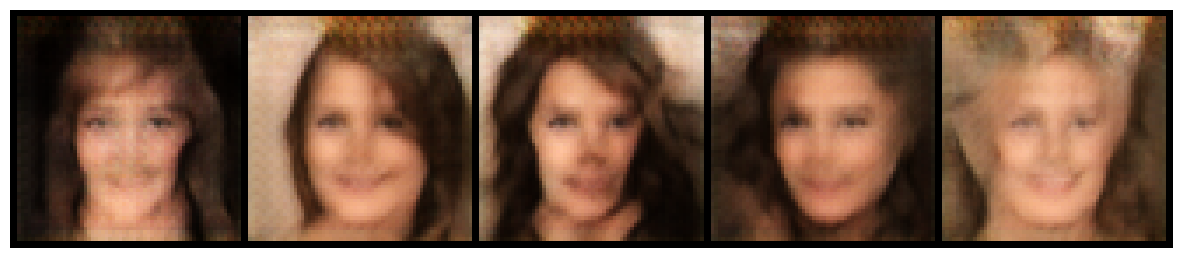

Epoch [31/200] Loss G: 1.1923142671585083, Loss D_F: 0.18958958983421326, Loss D_S: 0.22446411848068237
Generated images on fixed input after Epoch 31


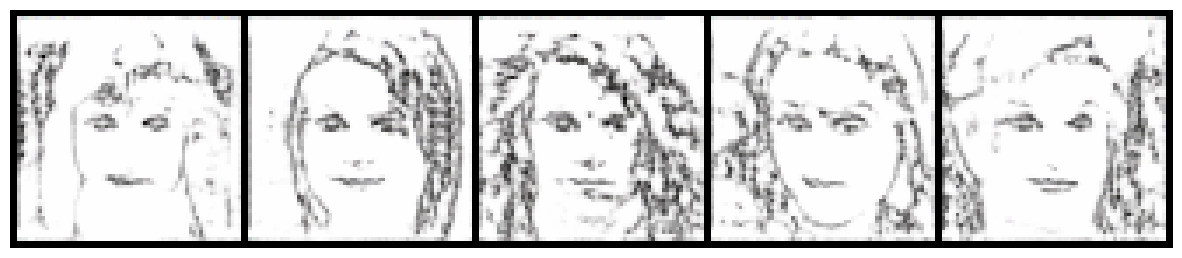

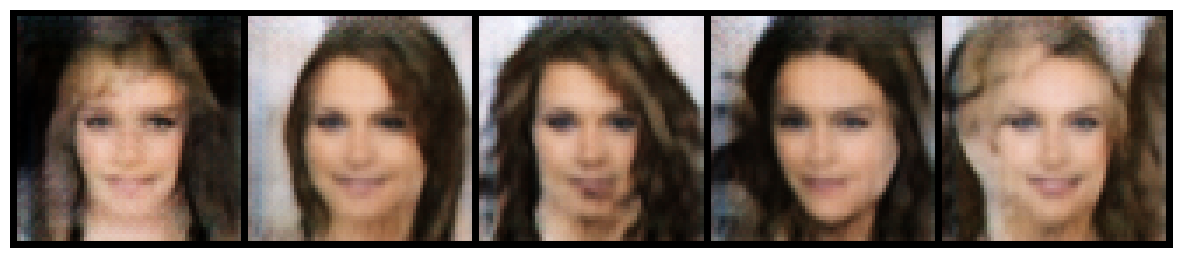

Epoch [32/200] Loss G: 2.2414677143096924, Loss D_F: 0.11945319175720215, Loss D_S: 0.013907908461987972
Generated images on fixed input after Epoch 32


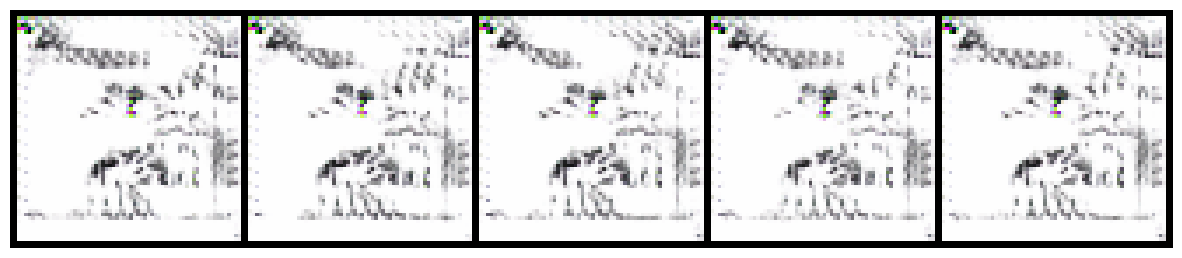

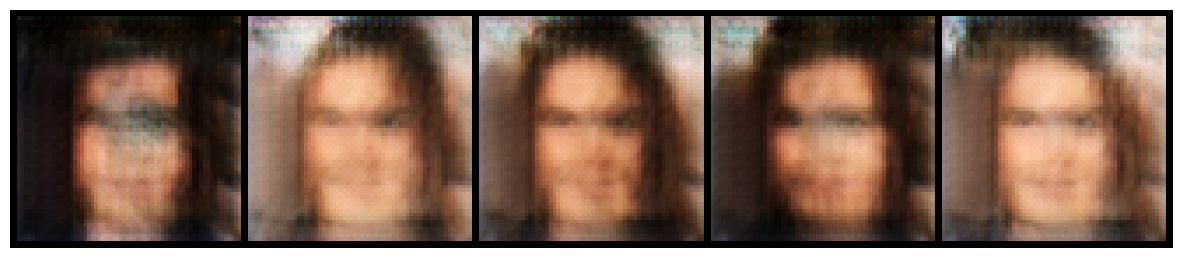

Epoch [33/200] Loss G: 2.069826602935791, Loss D_F: 0.18310409784317017, Loss D_S: 0.0015220735222101212
Generated images on fixed input after Epoch 33


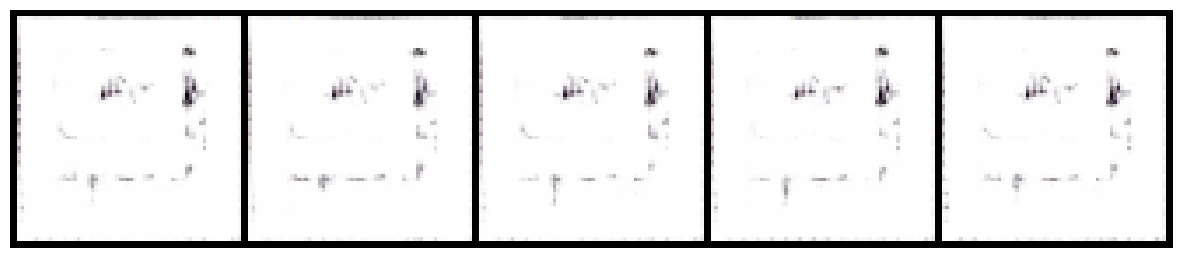

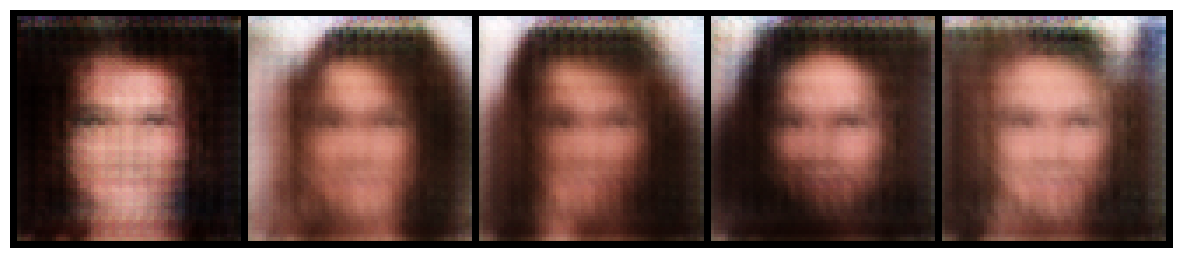

Epoch [34/200] Loss G: 1.943282961845398, Loss D_F: 0.1597280204296112, Loss D_S: 0.00090561289107427
Generated images on fixed input after Epoch 34


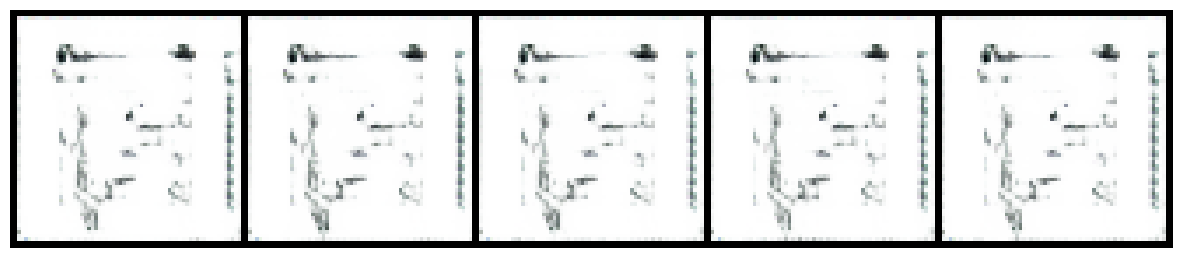

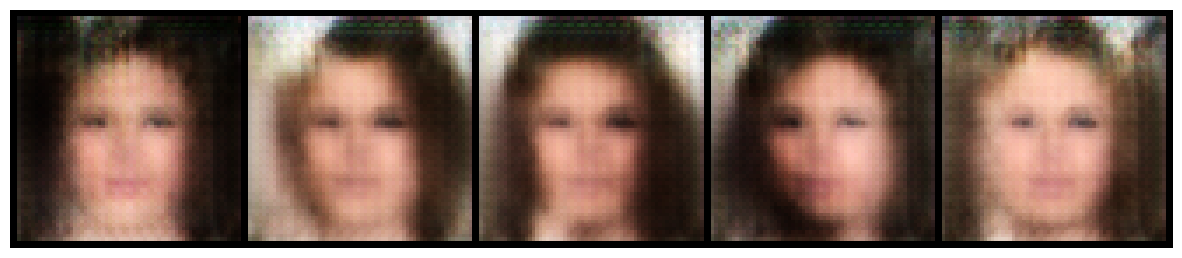

Epoch [35/200] Loss G: 2.1110281944274902, Loss D_F: 0.1271427422761917, Loss D_S: 0.0038165240548551083
Generated images on fixed input after Epoch 35


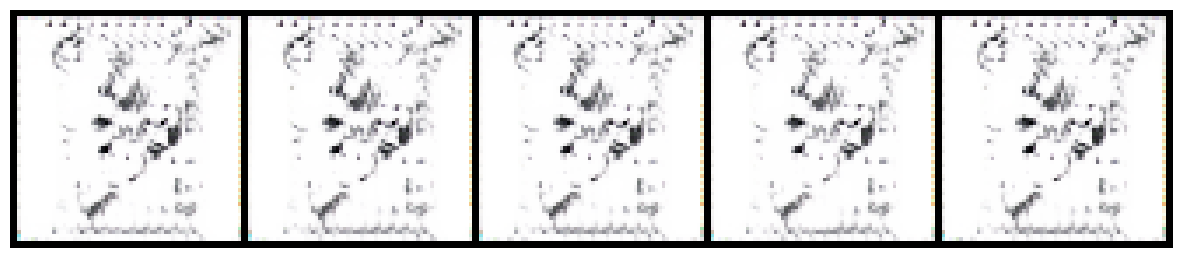

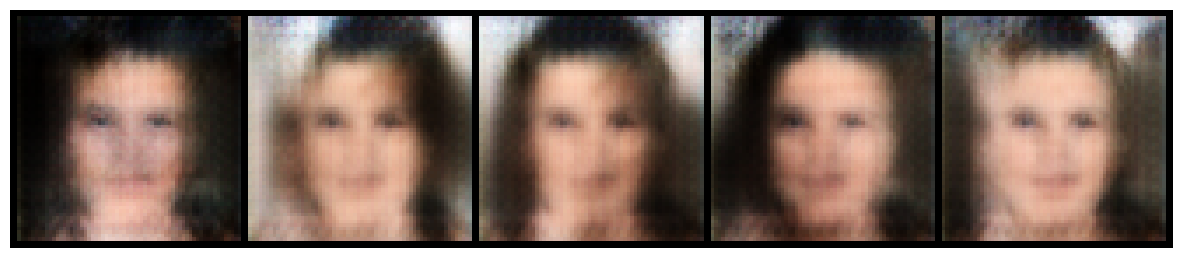

Epoch [36/200] Loss G: 1.6106575727462769, Loss D_F: 0.1887219101190567, Loss D_S: 0.2950360178947449
Generated images on fixed input after Epoch 36


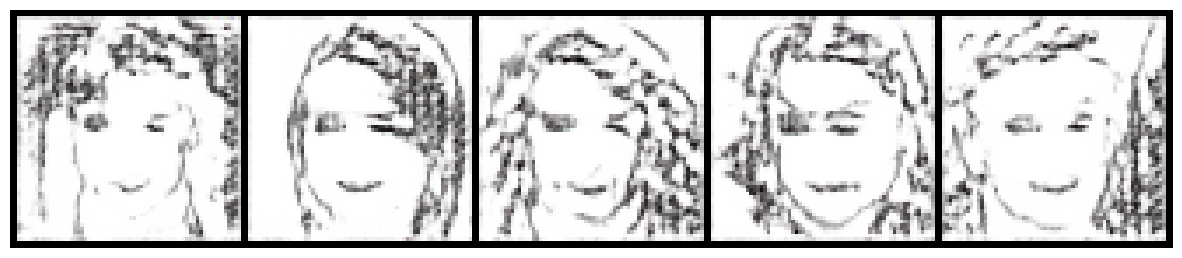

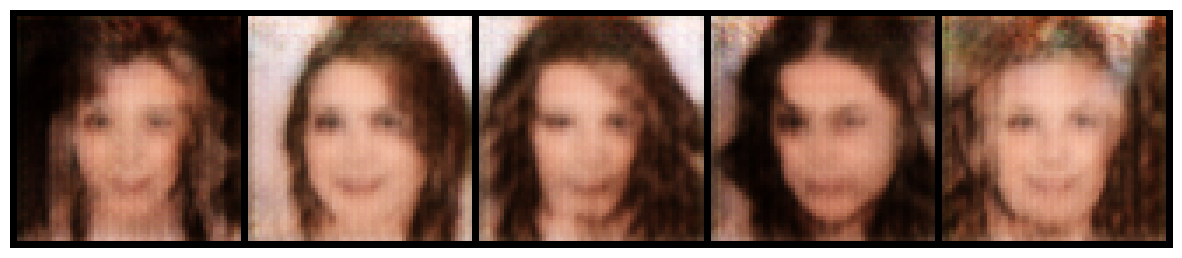

Epoch [37/200] Loss G: 1.5405068397521973, Loss D_F: 0.16373197734355927, Loss D_S: 0.12549349665641785
Generated images on fixed input after Epoch 37


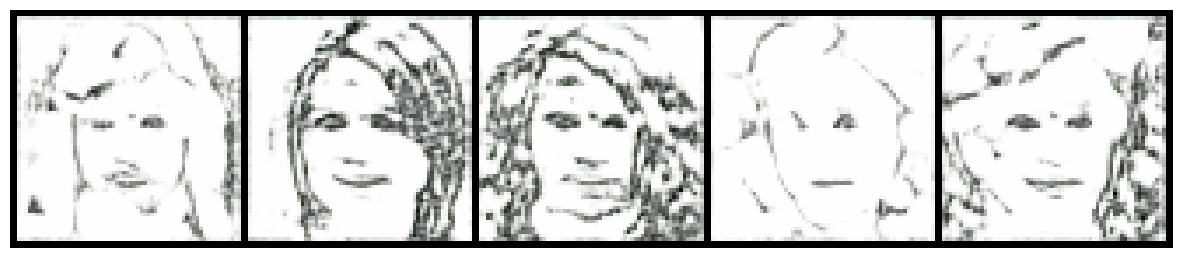

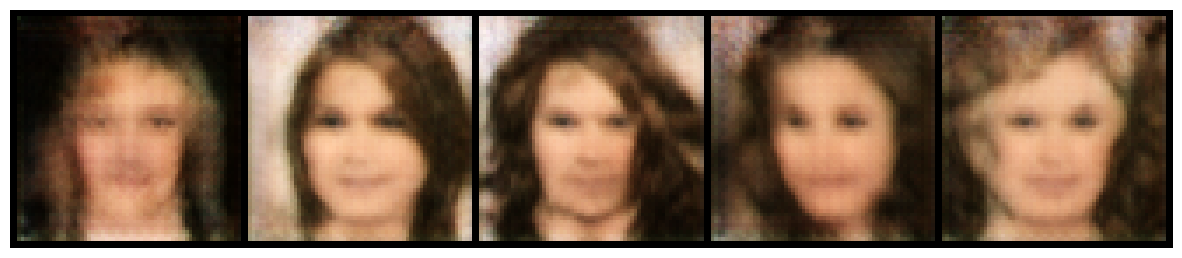

Epoch [38/200] Loss G: 1.1792172193527222, Loss D_F: 0.18276797235012054, Loss D_S: 0.21826612949371338
Generated images on fixed input after Epoch 38


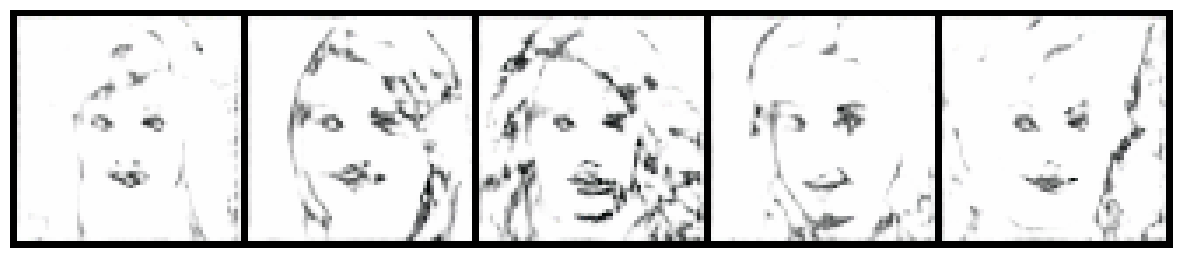

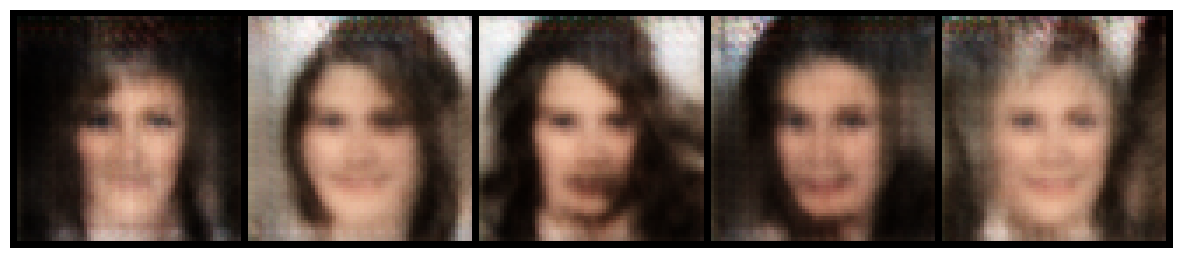

Epoch [39/200] Loss G: 1.8377490043640137, Loss D_F: 0.13137830793857574, Loss D_S: 0.12188969552516937
Generated images on fixed input after Epoch 39


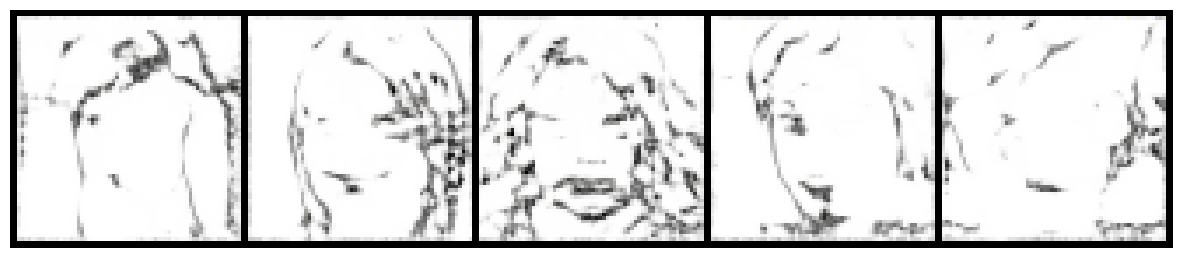

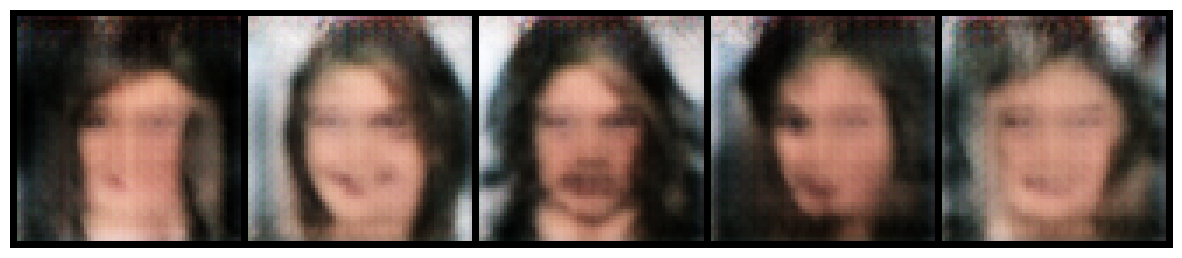

Epoch [40/200] Loss G: 1.2832484245300293, Loss D_F: 0.17506344616413116, Loss D_S: 0.21735844016075134
Generated images on fixed input after Epoch 40


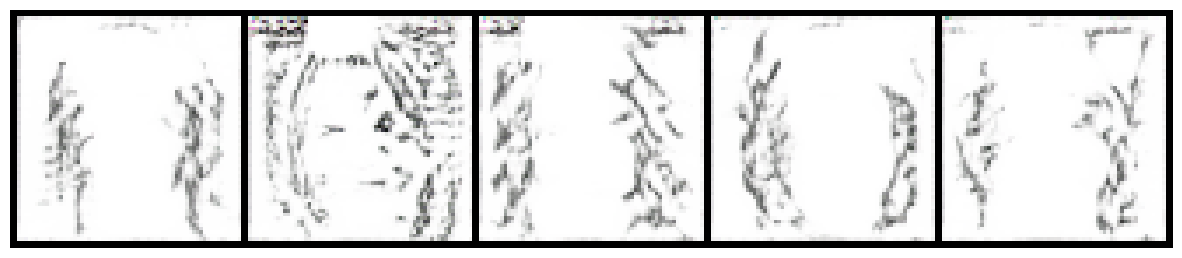

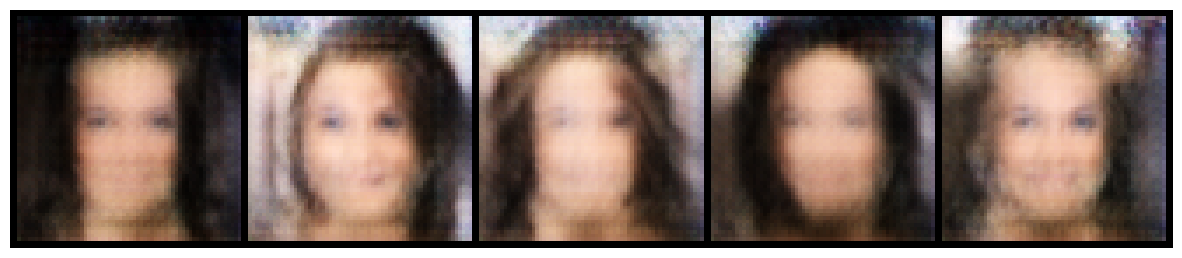

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(image_tensor, num_images=5, size=(64, 64)):
    image_tensor = image_tensor[:num_images]
    image_grid = vutils.make_grid(image_tensor, nrow=num_images, padding=2, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(image_grid.cpu(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

fixed_sketch, fixed_face = next(iter(test_loader))
fixed_sketch = fixed_sketch.to(device)
fixed_face = fixed_face.to(device)

n_epochs = 200
for epoch in range(n_epochs):
    
    for i, (sketch, face) in enumerate(train_loader):
        sketch = sketch.to(device)
        face = face.to(device)

        G_optimizer.zero_grad()

        same_sketch = G_FtoS(sketch)
        loss_identity_S = criterion_cycle(same_sketch, sketch)

        same_face = G_StoF(face)
        loss_identity_F = criterion_cycle(same_face, face)

        fake_sketch = G_FtoS(face)
        D_S_fake = D_S(fake_sketch)

        valid = torch.ones_like(D_S_fake).to(device)
        fake = torch.zeros_like(D_S_fake).to(device)

        loss_GAN_FtoS = criterion_GAN(D_S_fake, valid)

        fake_face = G_StoF(sketch)
        D_F_fake = D_F(fake_face)

        valid = torch.ones_like(D_F_fake).to(device)
        fake = torch.zeros_like(D_F_fake).to(device)

        loss_GAN_StoF = criterion_GAN(D_F_fake, valid)

        reconstructed_face = G_StoF(fake_sketch)
        loss_cycle_F = criterion_cycle(reconstructed_face, face)

        reconstructed_sketch = G_FtoS(fake_face)
        loss_cycle_S = criterion_cycle(reconstructed_sketch, sketch)

        loss_G = (loss_identity_F + loss_identity_S +
                  loss_GAN_FtoS + loss_GAN_StoF +
                  loss_cycle_F + loss_cycle_S)

        loss_G.backward()
        G_optimizer.step()

        D_F_optimizer.zero_grad()
        D_S_optimizer.zero_grad()

        real_D_F = D_F(face)
        fake_D_F = D_F(fake_face.detach())
        valid = torch.ones_like(real_D_F).to(device)
        fake = torch.zeros_like(fake_D_F).to(device)
        loss_D_F = (criterion_GAN(real_D_F, valid) + criterion_GAN(fake_D_F, fake)) / 2

        real_D_S = D_S(sketch)
        fake_D_S = D_S(fake_sketch.detach())
        valid = torch.ones_like(real_D_S).to(device)
        fake = torch.zeros_like(fake_D_S).to(device)
        loss_D_S = (criterion_GAN(real_D_S, valid) + criterion_GAN(fake_D_S, fake)) / 2

        loss_D_F.backward()
        loss_D_S.backward()

        D_F_optimizer.step()
        D_S_optimizer.step()

    print(f"Epoch [{epoch+1}/{n_epochs}] Loss G: {loss_G.item()}, Loss D_F: {loss_D_F.item()}, Loss D_S: {loss_D_S.item()}")

    G_FtoS.eval()  
    G_StoF.eval()

    with torch.no_grad():
        fixed_fake_sketch = G_FtoS(fixed_face)
        fixed_reconstructed_face = G_StoF(fixed_fake_sketch)

    print(f"Generated images on fixed input after Epoch {epoch+1}")
    show_images(fixed_fake_sketch)
    show_images(fixed_reconstructed_face)

    G_FtoS.train()  
    G_StoF.train()

In [14]:
torch.save(G_FtoS.state_dict(), "/kaggle/working/G_FtoS.pth")
torch.save(G_StoF.state_dict(), "/kaggle/working/G_StoF.pth")

G_FtoS.load_state_dict(torch.load("/kaggle/working/G_FtoS.pth"))
G_StoF.load_state_dict(torch.load("/kaggle/working/G_StoF.pth"))

/tmp/ipykernel_30/2821490288.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_FtoS.load_state_dict(torch.load("/kaggle/working/G_FtoS.pth"))
/tmp/ipykernel_30/282149028

<All keys matched successfully>

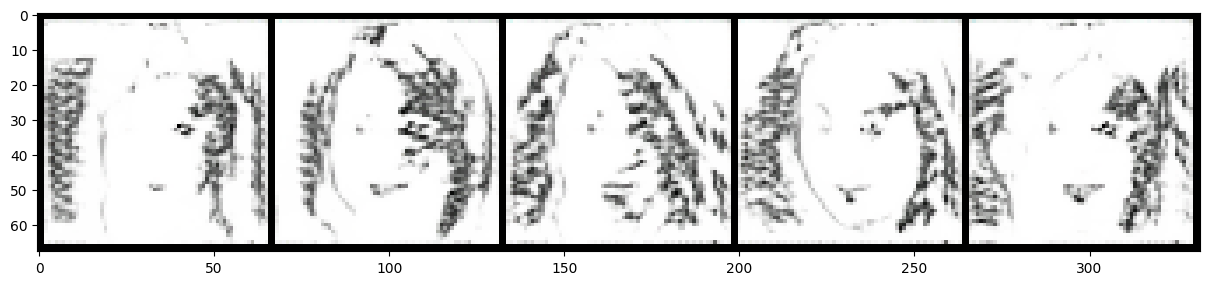

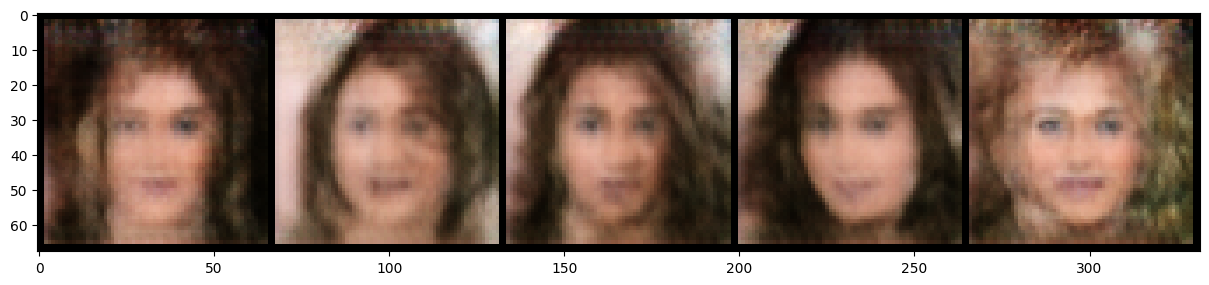

In [15]:
import matplotlib.pyplot as plt

def show_images(image_tensor, num_images=5, size=(64, 64)):
    image_tensor = image_tensor[:num_images]
    image_grid = vutils.make_grid(image_tensor, nrow=num_images, padding=2, normalize=True)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(image_grid.cpu(), (1,2,0)))
    plt.show()

G_FtoS.eval()  
G_StoF.eval()

sketch, face = next(iter(test_loader))
sketch = sketch.to(device)
face = face.to(device)

fake_sketch = G_FtoS(face)
reconstructed_face = G_StoF(fake_sketch)

show_images(fake_sketch)
show_images(reconstructed_face)